# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

Дата выдачи: 06.12.2021

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [115]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [116]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)
x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [118]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
%autoreload 2
from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

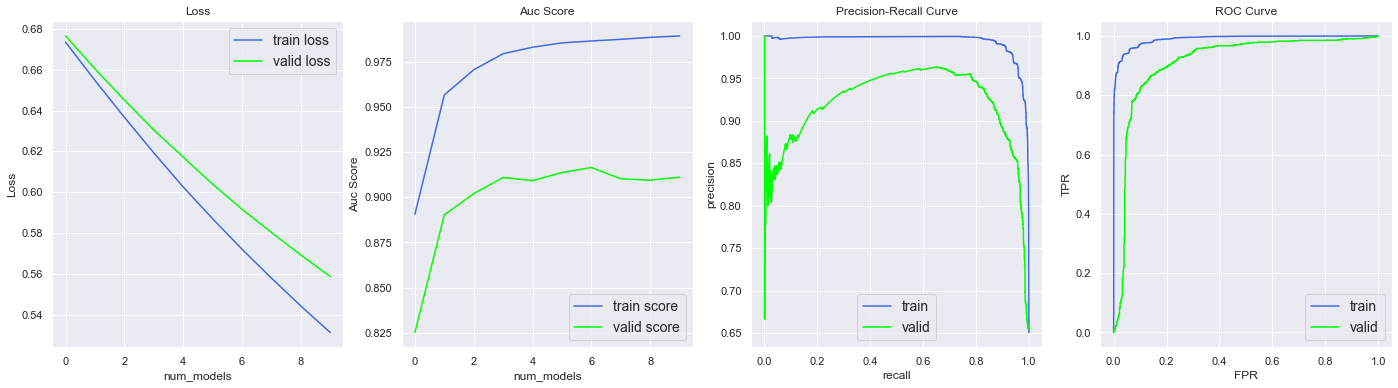

Wall time: 2.14 s
Train ROC-AUC 0.9893
Valid ROC-AUC 0.9112
Test ROC-AUC 0.9150


In [120]:
boosting = Boosting(plot=True)

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators
assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

# CPU times: user 924 ms, sys: 0 ns, total: 924 ms
# Wall time: 924 ms
# Train ROC-AUC 0.9921
# Valid ROC-AUC 0.9172
# Test ROC-AUC 0.9110

## Задание 2. Обучение градиентного бустинга (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [121]:
scores = {'Train':[], 'Valid':[], 'Test':[]}
depths = np.arange(1, 30, 2)
for dp in depths:
    b = Boosting(base_model_params={'max_depth': dp})
    b.fit(x_train, y_train, x_valid, y_valid)
    scores['Train'] += [b.score(x_train, y_train)]
    scores['Valid'] += [b.score(x_valid, y_valid)]
    scores['Test'] += [b.score(x_test, y_test)]

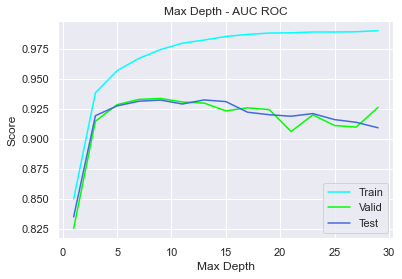

In [122]:
for title, color in zip(['Train', 'Valid', 'Test'], ['cyan', 'lime', 'royalblue']):
    plt.plot(depths, scores[title], color=color, label=title)
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Max Depth - AUC ROC')
plt.legend()
plt.show()

In [123]:
depths[[np.argmax(scores['Valid']), np.argmax(scores['Test'])]]

array([ 9, 13])

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Лучшего качества достигают модели с небольшой максимальной глубиной (около 10). Свыше - качество падает. Связано это с тем, что градиентный бустинг способствует снижению смещения ошибки, а чем больше глубина дерева, тем меньше смещение. Таким образом, если дать градиентному бустинг работать с глубокими деревьями, то мы очень быстро переобучимся.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (2 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей.

*Перебирать буду в отдельных циклах - так быстрее (насколько я знаю, это разрешено).*

In [167]:
from tqdm.notebook import tqdm

base_params = {
            'max_depth': depths,
            'min_samples_leaf': np.arange(3, 30, 3),
        }

boost_params = {
            'n_estimators': np.arange(5, 200, 15),
            'learning_rate': np.arange(0.02, 0.2, 0.02),
            'subsample': np.arange(0.05, 0.95, 0.05),
        }

def foo(base_params, boost_params):
    last = -1
    best_pair = {}
    for dp in tqdm(base_params['max_depth'], 'max_depth'):
        for msl in base_params['min_samples_leaf']:
            b = Boosting(base_model_params={'max_depth': dp,
                                            'min_samples_leaf': msl})
            b.fit(x_train, y_train, x_valid, y_valid)
            new = b.score(x_valid, y_valid)
            if new > last:
                best_pair['max_depth'] = dp
                best_pair['min_samples_leaf'] = msl
                last = new
                
    def foo_b(boost_params_, param_name):
        last = -1
        best_pr = None
        for pr in tqdm(boost_params[param_name], param_name):
            boost_params_[param_name] = pr
            b = Boosting(**boost_params_)
            b.fit(x_train, y_train, x_valid, y_valid)
            new = b.score(x_valid, y_valid)
            if new > last:
                best_pr, last = pr, new
        return best_pr
            
    best_boost = {}
    best_boost['base_model_params'] = best_pair
    best_boost['subsample'] = foo_b(best_boost, 'subsample')
    best_boost['n_estimators'] = foo_b(best_boost, 'n_estimators')
    best_boost['learning_rate'] = foo_b(best_boost, 'learning_rate')
    return best_boost

bbp = foo(base_params, boost_params)

In [168]:
bbp

{'base_model_params': {'max_depth': 29, 'min_samples_leaf': 15},
 'subsample': 0.7000000000000001,
 'n_estimators': 125,
 'learning_rate': 0.12000000000000001}

## Задание 4. Пробуем разные библиотеки (2 балла)

Выберите себе библиотеку с реализацией градиентного бустинга по вкусу из следующих трёх - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart). Подберите основные гиперпараметры, постарайтесь добиться наилучшего качества на тестовых данных. Сравните результаты своей реализации с результатами библиотечного бустинга.

In [169]:
from xgboost import XGBClassifier

### XGBoost

In [212]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# ss = StandardScaler()
# le = LabelEncoder()
# x_train_ = ss.fit_transform(x_train.A)
# x_valid_ = ss.fit_transform(x_valid.A)

# y_train_ = le.fit_transform(y_train)
# y_valid_ = le.fit_transform(y_valid)

XG_grid = {
        'learning_rate': np.arange(0.02, 0.2, 0.02),
        'subsample': np.arange(0.05, 0.95, 0.05),
        'max_depth': depths,
        'n_estimators': np.arange(5, 200, 15),
        'eta': np.logspace(-2, 0, 10),
    }

def foo_xgb(boost_params, param_name):
    last = -1
    best_pr = None
    for pr in tqdm(XG_grid[param_name], param_name):
        boost_params[param_name] = pr
        b = XGBClassifier(**boost_params)
        b.fit(x_train, y_train)
        y_pred = b.predict(x_valid)
        new = roc_auc_score(y_valid == 1, y_pred)
        if new > last:
            best_pr, last = pr, new
    return best_pr

XG_params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}
XG_params['subsample'] = foo_xgb(XG_params, 'subsample')
XG_params['max_depth'] = foo_xgb(XG_params, 'max_depth')
XG_params['learning_rate'] = foo_xgb(XG_params, 'learning_rate')
XG_params['n_estimators'] = foo_xgb(XG_params, 'n_estimators')
XG_params['eta'] = foo_xgb(XG_params, 'eta')

In [213]:
XG_params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'subsample': 0.8,
 'max_depth': 3,
 'learning_rate': 0.13999999999999999,
 'n_estimators': 125,
 'eta': 0.01}

In [214]:
b = XGBClassifier(**XG_params)
b.fit(x_train, y_train)
y_pred = b.predict(x_test)
xgb_score = roc_auc_score(y_test == 1, y_pred)

b = Boosting(**bbp)
b.fit(x_train, y_train, x_test, y_test)
bbp_score = b.score(x_test, y_test)

print('XGB:', xgb_score)
print('Handmade:', bbp_score)

XGB: 0.8601514982137318
Handmade: 0.9350043219974713


Идти выше XGB не хочет - качество чуть лучше 0.86, что значительно отличается от того, что мы получили с помощью самопального бустинга (кстати, здесь качество зависит от порядка подбора гиперпараметров). Скорее всего, связано это с тем, что я перебирал гиперпараметры отдельно (в идеале нужно смотреть по всевозможным комбинациям). На мой взгляд результаты должны быть как минимум близкими, но это интуитивное утверждение.

### Задание 5 (бонус). Пробуем ещё немножко библиотек (1 балл)

Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/). Сравните полученное качество с вашим ручным перебором. Используйте эту библиотеку чтобы подобрать параметры и для своей реалзиации и для библиотечной.

In [215]:
# YOUR CODE:

## Задание 6. Интерпретация бустингового (1 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга (из тех, что используют вашу реализацию).
Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регресии, сравните их между собой. Проанализируйте полученные результаты.

In [216]:
# YOUR CODE:

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

In [217]:
# YOUR CODE:

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [218]:
# YOUR CODE:

## Задание 7 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашими лучшими моделями (ваша реализация с лучшими гиперпараметрами + все модели из библиотек с лучшими гиперпараметрами). Улучшилось ли качество?

In [219]:
# YOUR CODE: